# Geschlechtserkennung

## Erkennung der Geschlechter mit CLIP auf den politischen Plakaten

In [1]:
# Die benötigten Pakete importieren
import os
import torch
from PIL import Image
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import torch.optim as optim
from torch import nn
from torchvision import transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

In [2]:
# Die CSV-Datei laden
csv_file = '/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/CLIP/train/_classes.csv'
df = pd.read_csv(csv_file)

In [3]:
# Pfad zu allen Bildern
image_folder = '/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/CLIP/test'
images = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.jpg', '.jpeg', '.png'))]

In [4]:
# Pfad zu den Bilder von der Sowjetunion
image_folder_USSR = '/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/USSR'
images_USSR = [os.path.join(image_folder_USSR, img) for img in os.listdir(image_folder_USSR) if img.endswith(('.jpg', '.jpeg', '.png'))]

In [5]:
# Pfad zu den Bilder von Nordkorea
image_folder_DPRK = '/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/DPRK'
images_DPRK = [os.path.join(image_folder_DPRK, img) for img in os.listdir(image_folder_DPRK) if img.endswith(('.jpg', '.jpeg', '.png'))]

In [6]:
# Pfad zu den Bildern, die zum Trainieren benutzt werden
train_image_folder ='/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/CLIP/train' 

In [7]:
# Bildtransformationen definieren
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

In [8]:
# Das vortrainierte CLIP-Model und den -Prozessor laden
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

In [9]:
# Die Geschlechtslabels definieren
labels_array = df[['man', 'woman']].values.astype(np.float32)
print(f"Labels array shape: {labels_array.shape}")

Labels array shape: (65, 2)


In [10]:
# Den labels-Tensor erstellen
labels = torch.tensor(labels_array)
print(f"Labels tensor shape: {labels.shape}")

Labels tensor shape: torch.Size([65, 2])


In [11]:
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, processor=None, model=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.processor = processor
        self.model = model

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        inputs = self.processor(images=image, return_tensors="pt", do_rescale=False)

        with torch.no_grad():
            image_embedding = self.model.get_image_features(**inputs)
            
        if self.labels is not None:
            label = self.labels[idx]
            return {'image_embedding': image_embedding.squeeze(0), 'labels': label}
        else:
            return {'image_embedding': image_embedding.squeeze(0)}

In [12]:
train_images = [os.path.join(train_image_folder, filename) for filename in df['filename']]

In [13]:
# Einen Multilabel-CLassifier definieren
class MultiLabelClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MultiLabelClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x.view(x.size(0), -1))
        return self.sigmoid(x)

In [14]:
# k-Fold Kreuzvalidierung
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [15]:
best_classifier = None
best_val_loss = float('inf')
best_classifier_save_path = '/home/sc.uni-leipzig.de/lj25vapa/Cultural Analytics/gender_classifier.pth'

In [16]:
train_images_array = np.array(train_images)

In [17]:
for fold, (train_index, val_index) in enumerate(kf.split(train_images)):
    print(f'Fold {fold + 1}/{k}')

    print(f"Number of train samples: {len(train_index)}")
    print(f"Number of validation samples: {len(val_index)}")

    labels = torch.tensor(labels_array)

    print(f"labels shape: {labels.shape}")
    
    X_train_fold = [train_images[i] for i in train_index]
    X_val_fold = [train_images[i] for i in val_index]
    y_train_fold = labels[train_index]
    y_val_fold = labels[val_index]

    print(f"X_train_fold length: {len(X_train_fold)}")
    print(f"X_val_fold length: {len(X_val_fold)}")
    print(f"y_train_fold shape: {y_train_fold.shape}")
    print(f"y_val_fold shape: {y_val_fold.shape}")

    train_dataset = MyDataset(X_train_fold, y_train_fold, transform=transform, processor=processor, model=model)
    val_dataset = MyDataset(X_val_fold, y_val_fold, transform=transform, processor=processor, model=model)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Den Classifier, den Optimizer und die Verlustfunktion initialisieren
    classifier = MultiLabelClassifier(input_dim=512)
    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    criterion = nn.BCELoss()

    # Training
    classifier.train()
    for epoch in range(10):
        for batch in train_loader:
            image_embeddings = batch['image_embedding']
            labels = batch['labels']
            optimizer.zero_grad()
            predictions = classifier(image_embeddings)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
    # Evaluierung
    classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            image_embeddings = batch['image_embedding']
            labels = batch['labels']
            predictions = classifier(image_embeddings)
            loss = criterion(predictions, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Validationsloss für Fold {fold + 1}: {avg_val_loss:.4f}')

    # Das trainierte Model speichern
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_classifier = classifier.state_dict()
        torch.save(best_classifier, best_classifier_save_path)
        print(f"Classifier für Fold {fold + 1} als bester Classifier gespeichert.")

print(f"Der beste Classifier ist auf: {best_classifier_save_path}")

Fold 1/5
Number of train samples: 52
Number of validation samples: 13
labels shape: torch.Size([65, 2])
X_train_fold length: 52
X_val_fold length: 13
y_train_fold shape: torch.Size([52, 2])
y_val_fold shape: torch.Size([13, 2])
Validationsloss für Fold 1: 0.8237
Classifier für Fold 1 als bester Classifier gespeichert.
Fold 2/5
Number of train samples: 52
Number of validation samples: 13
labels shape: torch.Size([65, 2])
X_train_fold length: 52
X_val_fold length: 13
y_train_fold shape: torch.Size([52, 2])
y_val_fold shape: torch.Size([13, 2])
Validationsloss für Fold 2: 0.7448
Classifier für Fold 2 als bester Classifier gespeichert.
Fold 3/5
Number of train samples: 52
Number of validation samples: 13
labels shape: torch.Size([65, 2])
X_train_fold length: 52
X_val_fold length: 13
y_train_fold shape: torch.Size([52, 2])
y_val_fold shape: torch.Size([13, 2])
Validationsloss für Fold 3: 0.7612
Fold 4/5
Number of train samples: 52
Number of validation samples: 13
labels shape: torch.Size([6

In [18]:
def evaluate_dataset(images, dataset_name, transform, processor, model, classifier, best_classifier_save_path):
    classifier.load_state_dict(torch.load(best_classifier_save_path))
    classifier.eval()
    
    dataset = MyDataset(images, labels=None, transform=transform, processor=processor, model=model)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

    threshold = 0.5
    results = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            image_embeddings = batch['image_embedding']
            
            predictions = classifier(image_embeddings)
            probabilities = predictions.sigmoid().cpu().numpy()

            for i, probability in enumerate(probabilities):
                man_probability = probability[0]
                woman_probability = probability[1]
    
                if man_probability >= threshold and man_probability > woman_probability:
                    category = "Man"
                elif woman_probability >= threshold and woman_probability > man_probability:
                    category = "Woman"
                else:
                    category = "Neither"

                image_idx = batch_idx * 32 + i
                if image_idx < len(images):
                    results.append({
                        "Image": images[image_idx],
                        "Predicted Category": category,
                        "Man Probability": man_probability, 
                        "Woman Probability": woman_probability
                    })

    results_file = f'{dataset_name}_gender_detection_results.csv'
    with open(results_file, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=results[0].keys())
        writer.writeheader()
        writer.writerows(results)

    print(f"Ergebnis auf {results_file} gespeichert")

    df = pd.read_csv(results_file)
    counts = df['Predicted Category'].value_counts()
    counts = counts.reindex(['Man', 'Woman', 'Neither'], fill_value=0)
    percentages = (counts / counts.sum()) * 100

    plt.figure(figsize=(8, 6))
    plt.bar(percentages.index, percentages.values)
    plt.xlabel("Vorhergesagte Kategorie")
    plt.ylabel("Prozentsatz")
    plt.title("Verteilung der vorhergesagten Geschlechterkategorien")
    plt.show()

## Alle Bilder

Ergebnis auf Alle_gender_detection_results.csv gespeichert


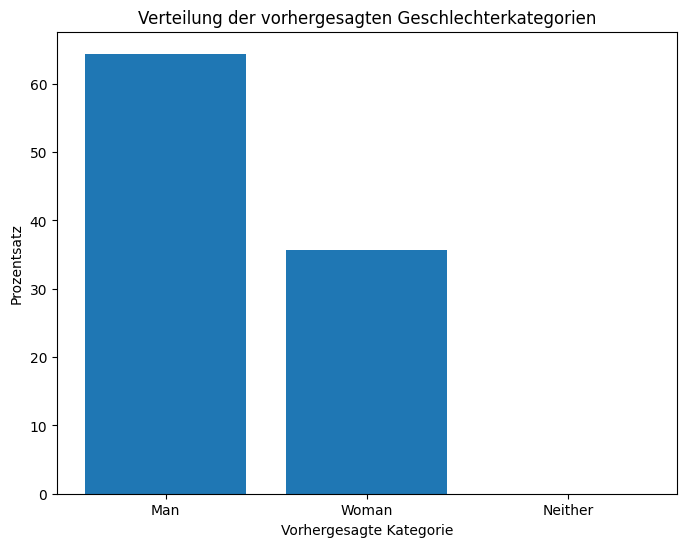

In [19]:
evaluate_dataset(images, "Alle", transform, processor, model, classifier, best_classifier_save_path)

## Sowjetunion

Ergebnis auf USSR_gender_detection_results.csv gespeichert


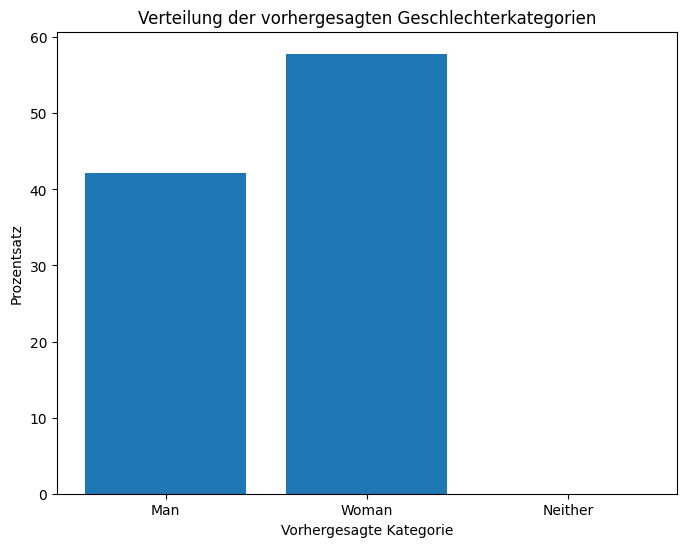

In [20]:
evaluate_dataset(images_USSR, "USSR", transform, processor, model, classifier, best_classifier_save_path)

## Nordkorea

Ergebnis auf DPRK_gender_detection_results.csv gespeichert


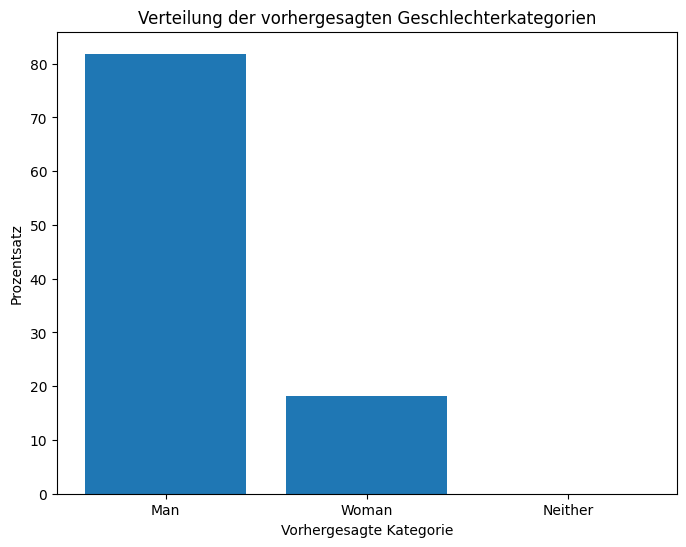

In [21]:
evaluate_dataset(images_DPRK, "DPRK", transform, processor, model, classifier, best_classifier_save_path)